# Transformer–GAN–Contrastive Anomaly Detection on Credit Card Fraud Dataset

End-to-end implementation of a **Transformer-based autoencoder** with **contrastive learning** and a **latent-space WGAN** for anomaly detection on the Kaggle *Credit Card Fraud Detection* dataset.

Place `creditcard.csv` at `/mnt/data/creditcard.csv` (or change `DATA_PATH`).

In [ ]:

# ============================================================================
# IMPORTS & SETUP
# ============================================================================

import os
import math
import random
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    roc_auc_score,
    precision_recall_curve,
    auc,
    roc_curve,
    classification_report,
    confusion_matrix
)

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset

import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-darkgrid')

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SEED = 42

np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

print(f"✓ Using device: {DEVICE}")


✓ Using device: cuda


In [ ]:

# ============================================================================
# CONFIGURATION
# ============================================================================

DATA_PATH = "/mnt/data/creditcard.csv"  # change if needed

# Sliding window
WINDOW_SIZE = 30
STEP = 1

# Model
D_MODEL = 128
NHEAD = 8
NUM_ENCODER_LAYERS = 3
LATENT_DIM = 16

# Training
BATCH_SIZE = 256
EPOCHS = 30
LEARNING_RATE = 3e-4

# Loss weights
W_RECON = 1.0
W_CONTRAST = 0.05
W_ADV = 0.02
CONTRAST_WARMUP_EPOCHS = 5

# WGAN
N_CRITIC = 3
CLIP_VALUE = 0.05

# Augmentation
TIME_MASK_PROB = 0.1
FEATURE_MASK_PROB = 0.1
NOISE_STD = 0.01

print("✓ Configuration loaded")


✓ Configuration loaded


In [ ]:

# ============================================================================
# DATA LOADING, CLEANING, SEQUENCE GENERATION
# ============================================================================

print("📥 Loading dataset...")
df = pd.read_csv(DATA_PATH)
print("Raw shape:", df.shape)

# Ensure columns
assert "Class" in df.columns, "Dataset must contain 'Class' column."
assert "Time" in df.columns, "Dataset must contain 'Time' column."

# Clean
df = df.dropna(subset=["Class"]).reset_index(drop=True)
df["Class"] = df["Class"].astype(float).astype(int)
df = df.apply(pd.to_numeric, errors="coerce")
df = df.dropna().reset_index(drop=True)

print("Cleaned shape:", df.shape)
print("Class distribution:")
print(df["Class"].value_counts())

# Sort by time
df = df.sort_values(by="Time").reset_index(drop=True)
print("✓ Sorted by Time")

# Features & labels
features = df.drop(columns=["Class"]).columns.tolist()
X_raw = df[features].values
y_raw = df["Class"].values

print("Feature shape:", X_raw.shape)

# Scale
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_raw)
print("✓ Features standardized")

# Sequence generation
def create_sequences(data, labels, window, step):
    seqs, seq_labels = [], []
    n = len(data)
    for i in range(0, n - window, step):
        w_data = data[i:i+window]
        w_lab = labels[i:i+window]
        if np.isnan(w_lab).any():
            continue
        seqs.append(w_data)
        seq_labels.append(int(w_lab.max()))
    return np.array(seqs), np.array(seq_labels)

print(f"🛠 Generating sequences (window={WINDOW_SIZE}, step={STEP})...")
X_seq, y_seq = create_sequences(X_scaled, y_raw, WINDOW_SIZE, STEP)

print("Sequences shape:", X_seq.shape)
print("Labels shape:", y_seq.shape)
print(f"Sequence anomaly ratio: {y_seq.mean()*100:.4f}%")

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_seq,
    y_seq,
    test_size=0.2,
    random_state=SEED,
    stratify=y_seq
)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)

# Tensors
X_train_t = torch.tensor(X_train, dtype=torch.float32)
X_test_t  = torch.tensor(X_test, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.long)
y_test_t  = torch.tensor(y_test, dtype=torch.long)

print("✓ Converted to torch tensors")


📥 Loading dataset...
Raw shape: (69415, 31)
Cleaned shape: (69414, 31)
Class distribution:
Class
0    69241
1      173
Name: count, dtype: int64
✓ Sorted by Time
Feature shape: (69414, 30)
✓ Features standardized
🛠 Generating sequences (window=30, step=1)...
Sequences shape: (69384, 30, 30)
Labels shape: (69384,)
Sequence anomaly ratio: 6.4929%
Train shape: (55507, 30, 30)
Test shape: (13877, 30, 30)
✓ Converted to torch tensors


In [ ]:

# ============================================================================
# DATASET & GEOMETRIC MASKING
# ============================================================================

class SequenceDataset(Dataset):
    def __init__(self, sequences, labels=None):
        self.sequences = sequences
        self.labels = labels

    def __len__(self):
        return self.sequences.shape[0]

    def __getitem__(self, idx):
        x = self.sequences[idx]
        if self.labels is None:
            return x
        y = self.labels[idx]
        return x, y


def geometric_masking(batch, time_mask_prob=0.1, feature_mask_prob=0.1, noise_std=0.01):
    augmented = batch.clone()
    B, T, F = augmented.shape

    if time_mask_prob > 0:
        time_mask = (torch.rand(B, T, device=augmented.device) < time_mask_prob).unsqueeze(-1)
        augmented = augmented.masked_fill(time_mask, 0.0)

    if feature_mask_prob > 0:
        feat_mask = (torch.rand(B, 1, F, device=augmented.device) < feature_mask_prob)
        augmented = augmented.masked_fill(feat_mask, 0.0)

    if noise_std > 0:
        augmented = augmented + torch.randn_like(augmented) * noise_std

    return augmented

print("✓ SequenceDataset and geometric_masking ready")


✓ SequenceDataset and geometric_masking ready


In [ ]:

# ============================================================================
# POSITIONAL ENCODING
# ============================================================================

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float32).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer("pe", pe.unsqueeze(0))

    def forward(self, x):
        T = x.size(1)
        return x + self.pe[:, :T]

print("✓ PositionalEncoding defined")


✓ PositionalEncoding defined


In [ ]:

# ============================================================================
# TRANSFORMER AUTOENCODER
# ============================================================================

class TransformerAutoencoder(nn.Module):
    def __init__(self, feat_dim, d_model=64, nhead=4, num_layers=2, latent_dim=16):
        super().__init__()
        self.input_fc = nn.Linear(feat_dim, d_model)
        self.pos_enc = PositionalEncoding(d_model, max_len=500)

        enc_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=256,
            batch_first=True
        )
        self.encoder_tf = nn.TransformerEncoder(enc_layer, num_layers=num_layers)

        self.latent_fc = nn.Linear(d_model, latent_dim)

        self.dec_input_fc = nn.Linear(latent_dim, d_model)
        dec_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=256,
            batch_first=True
        )
        self.decoder_tf = nn.TransformerEncoder(dec_layer, num_layers=2)
        self.pos_dec = PositionalEncoding(d_model, max_len=500)
        self.output_fc = nn.Linear(d_model, feat_dim)

        self._init_weights()

    def _init_weights(self):
        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)

    def encode(self, x):
        h = self.input_fc(x)
        h = self.pos_enc(h)
        h = self.encoder_tf(h)
        z = self.latent_fc(h[:, 0])
        return z

    def decode(self, z, seq_len):
        h = self.dec_input_fc(z).unsqueeze(1).repeat(1, seq_len, 1)
        h = self.pos_dec(h)
        h = self.decoder_tf(h)
        out = self.output_fc(h)
        return out

    def forward(self, x):
        z = self.encode(x)
        recon = self.decode(z, x.size(1))
        return z, recon

print("✓ TransformerAutoencoder defined")

✓ TransformerAutoencoder defined


In [ ]:

# ============================================================================
# GENERATOR & DISCRIMINATOR (LATENT WGAN)
# ============================================================================

def build_generator(latent_dim):
    gen = nn.Sequential(
        nn.Linear(latent_dim, 128),
        nn.ReLU(),
        nn.Linear(128, 128),
        nn.ReLU(),
        nn.Linear(128, latent_dim)
    )
    for p in gen.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform_(p)
    return gen


def build_discriminator(latent_dim):
    disc = nn.Sequential(
        nn.Linear(latent_dim, 128),
        nn.LeakyReLU(0.2),
        nn.Linear(128, 64),
        nn.LeakyReLU(0.2),
        nn.Linear(64, 32),
        nn.LeakyReLU(0.2),
        nn.Linear(32, 1)
    )
    for p in disc.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform_(p)
    return disc

print("✓ Generator & Discriminator defined")


✓ Generator & Discriminator defined


In [ ]:

# ============================================================================
# NT-XENT CONTRASTIVE LOSS
# ============================================================================

def nt_xent_loss(z1, z2, temperature=0.5):
    z1 = F.normalize(z1, dim=1, eps=1e-8)
    z2 = F.normalize(z2, dim=1, eps=1e-8)
    B = z1.size(0)
    z = torch.cat([z1, z2], dim=0)
    sim = torch.matmul(z, z.T) / temperature
    mask = torch.eye(2*B, dtype=torch.bool, device=z.device)
    sim = sim.masked_fill(mask, -1e9)
    labels = torch.cat([
        torch.arange(B, 2*B),
        torch.arange(0, B)
    ], dim=0).to(z.device)
    loss = F.cross_entropy(sim, labels)
    return loss

print("✓ NT-Xent defined")


✓ NT-Xent defined


In [ ]:

# ============================================================================
# INSTANTIATE MODELS, OPTIMIZERS, DATALOADER
# ============================================================================

feat_dim = len(features)

model = TransformerAutoencoder(
    feat_dim=feat_dim,
    d_model=D_MODEL,
    nhead=NHEAD,
    num_layers=NUM_ENCODER_LAYERS,
    latent_dim=LATENT_DIM
).to(DEVICE)

generator = build_generator(LATENT_DIM).to(DEVICE)
discriminator = build_discriminator(LATENT_DIM).to(DEVICE)

def count_parameters(m):
    return sum(p.numel() for p in m.parameters() if p.requires_grad)

print("Autoencoder params:", count_parameters(model))
print("Generator params:  ", count_parameters(generator))
print("Discriminator params:", count_parameters(discriminator))

optimizer_ae = torch.optim.Adam(
    model.parameters(),
    lr=LEARNING_RATE,
    weight_decay=1e-5,
    betas=(0.9, 0.999)
)
optimizer_gen = torch.optim.Adam(
    generator.parameters(),
    lr=LEARNING_RATE * 0.5,
    betas=(0.5, 0.999)
)
optimizer_disc = torch.optim.RMSprop(
    discriminator.parameters(),
    lr=LEARNING_RATE * 0.25
)

train_dataset = SequenceDataset(X_train_t, y_train_t)
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True
)

train_anom = float(y_train_t.float().mean()) * 100
print(f"✓ DataLoader: {len(train_loader)} batches, anomaly ratio {train_anom:.4f}%")


Autoencoder params: 674478
Generator params:   20752
Discriminator params: 12545
✓ DataLoader: 216 batches, anomaly ratio 6.4929%


In [ ]:

# ============================================================================
# TRAINING LOOP
# ============================================================================

history = {
    "epoch": [],
    "recon_loss": [],
    "contrast_loss": [],
    "enc_adv_loss": [],
    "disc_loss": [],
    "gen_loss": []
}

print("STARTING TRAINING")

for epoch in range(EPOCHS):
    model.train()
    generator.train()
    discriminator.train()

    epoch_recon = 0.0
    epoch_contrast = 0.0
    epoch_encadv = 0.0
    epoch_disc = 0.0
    epoch_gen = 0.0

    for batch_idx, (seq, labels) in enumerate(train_loader):
        seq = seq.to(DEVICE)

        aug = geometric_masking(
            seq,
            time_mask_prob=TIME_MASK_PROB,
            feature_mask_prob=FEATURE_MASK_PROB,
            noise_std=NOISE_STD
        )

        # 1) AE + contrastive + encoder adv
        optimizer_ae.zero_grad()
        z1, recon1 = model(seq)
        z2, recon2 = model(aug)

        recon_loss = F.mse_loss(recon1, seq)
        contrast_loss = nt_xent_loss(z1, z2, temperature=0.5)
        contrast_weight = 0.0 if epoch < CONTRAST_WARMUP_EPOCHS else W_CONTRAST
        enc_adv = -torch.mean(discriminator(z1))

        ae_loss = W_RECON * recon_loss + contrast_weight * contrast_loss + W_ADV * enc_adv
        ae_loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer_ae.step()

        # 2) Discriminator
        if batch_idx % N_CRITIC == 0:
            for _ in range(N_CRITIC):
                optimizer_disc.zero_grad()
                noise = torch.randn(seq.size(0), LATENT_DIM, device=DEVICE)
                z_fake = generator(noise)
                with torch.no_grad():
                    z_real = model.encode(seq)
                real_scores = discriminator(z_real)
                fake_scores = discriminator(z_fake.detach())
                disc_loss = -torch.mean(real_scores) + torch.mean(fake_scores)
                disc_loss.backward()
                optimizer_disc.step()
                for p in discriminator.parameters():
                    p.data.clamp_(-CLIP_VALUE, CLIP_VALUE)

        # 3) Generator
        if batch_idx % N_CRITIC == 0:
            optimizer_gen.zero_grad()
            noise = torch.randn(seq.size(0), LATENT_DIM, device=DEVICE)
            z_fake = generator(noise)
            gen_loss = -torch.mean(discriminator(z_fake))
            gen_loss.backward()
            optimizer_gen.step()
            epoch_gen += gen_loss.item()

        epoch_recon += recon_loss.item()
        epoch_contrast += contrast_loss.item()
        epoch_encadv += enc_adv.item()
        if batch_idx % N_CRITIC == 0:
            epoch_disc += disc_loss.item()

    n_batches = len(train_loader)
    n_disc_updates = max(n_batches // N_CRITIC, 1)

    avg_recon = epoch_recon / n_batches
    avg_contrast = epoch_contrast / n_batches
    avg_encadv = epoch_encadv / n_batches
    avg_disc = epoch_disc / n_disc_updates
    avg_gen = epoch_gen / n_disc_updates

    history["epoch"].append(epoch + 1)
    history["recon_loss"].append(avg_recon)
    history["contrast_loss"].append(avg_contrast)
    history["enc_adv_loss"].append(avg_encadv)
    history["disc_loss"].append(avg_disc)
    history["gen_loss"].append(avg_gen)

    print(
        f"Epoch {epoch+1:02d}/{EPOCHS} | "
        f"Recon: {avg_recon:.5f} | "
        f"Contrast: {avg_contrast:.5f} | "
        f"EncAdv: {avg_encadv:.5f} | "
        f"Disc: {avg_disc:.5f} | "
        f"Gen: {avg_gen:.5f}"
    )

print("TRAINING COMPLETED")


STARTING TRAINING
Epoch 01/30 | Recon: 0.98765 | Contrast: 6.06031 | EncAdv: -0.52795 | Disc: -0.48464 | Gen: -0.04539
Epoch 02/30 | Recon: 0.91323 | Contrast: 6.22073 | EncAdv: -14.09697 | Disc: -9.03703 | Gen: -5.06938
Epoch 03/30 | Recon: 0.91594 | Contrast: 6.23566 | EncAdv: -91.86799 | Disc: -43.30442 | Gen: -48.76847
Epoch 04/30 | Recon: 0.92224 | Contrast: 6.23624 | EncAdv: -258.10751 | Disc: -60.32342 | Gen: -198.16943
Epoch 05/30 | Recon: 0.92870 | Contrast: 6.23632 | EncAdv: -373.53111 | Disc: -5.48422 | Gen: -367.48425
Epoch 06/30 | Recon: 0.92783 | Contrast: 6.23630 | EncAdv: -178.51946 | Disc: 12.12705 | Gen: -190.08140
Epoch 07/30 | Recon: 0.91595 | Contrast: 6.23629 | EncAdv: -75.53185 | Disc: -1.31119 | Gen: -74.08895
Epoch 08/30 | Recon: 0.91691 | Contrast: 6.23631 | EncAdv: -113.43490 | Disc: -62.99557 | Gen: -49.91722
Epoch 09/30 | Recon: 0.91939 | Contrast: 6.23632 | EncAdv: -167.85519 | Disc: -181.50103 | Gen: 14.08275
Epoch 10/30 | Recon: 0.92310 | Contrast: 6.236

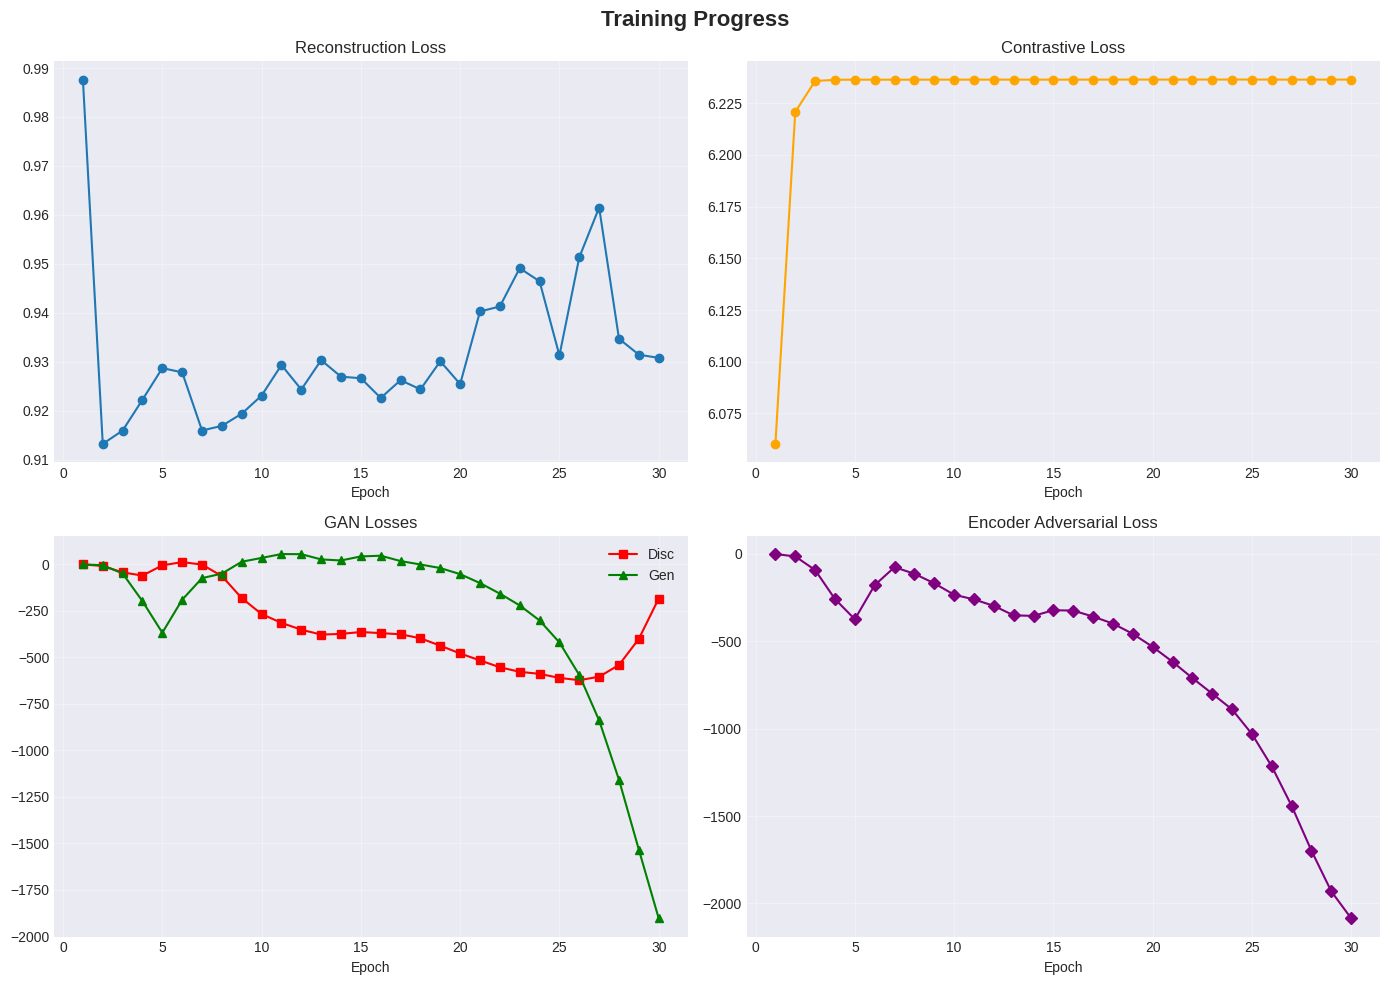

In [ ]:

# ============================================================================
# TRAINING CURVES
# ============================================================================

if len(history["epoch"]) > 0:
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle("Training Progress", fontsize=16, fontweight="bold")

    axes[0, 0].plot(history["epoch"], history["recon_loss"], marker="o")
    axes[0, 0].set_title("Reconstruction Loss")

    axes[0, 1].plot(history["epoch"], history["contrast_loss"], marker="o", color="orange")
    axes[0, 1].set_title("Contrastive Loss")

    axes[1, 0].plot(history["epoch"], history["disc_loss"], marker="s", label="Disc", color="red")
    axes[1, 0].plot(history["epoch"], history["gen_loss"], marker="^", label="Gen", color="green")
    axes[1, 0].set_title("GAN Losses")
    axes[1, 0].legend()

    axes[1, 1].plot(history["epoch"], history["enc_adv_loss"], marker="D", color="purple")
    axes[1, 1].set_title("Encoder Adversarial Loss")

    for ax in axes.flat:
        ax.set_xlabel("Epoch")
        ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()
else:
    print("No history to plot.")


In [ ]:

# ============================================================================
# EVALUATION ON TEST SET
# ============================================================================

model.eval()
all_scores = []
all_labels = []

test_dataset = TensorDataset(X_test_t, y_test_t)
test_loader = DataLoader(test_dataset, batch_size=512, shuffle=False)

with torch.no_grad():
    for seq, labels in test_loader:
        seq = seq.to(DEVICE)
        labels = labels.to(DEVICE)
        z, recon = model(seq)
        mse = F.mse_loss(recon, seq, reduction="none")
        mse = mse.mean(dim=(1, 2))
        all_scores.append(mse.cpu().numpy())
        all_labels.append(labels.cpu().numpy())

all_scores = np.concatenate(all_scores)
all_labels = np.concatenate(all_labels)

roc_auc = roc_auc_score(all_labels, all_scores)
precision, recall, _ = precision_recall_curve(all_labels, all_scores)
pr_auc = auc(recall, precision)

fpr, tpr, thresholds = roc_curve(all_labels, all_scores)
youden = tpr - fpr
best_idx = np.argmax(youden)
best_thresh = thresholds[best_idx]

print("ROC-AUC:", roc_auc)
print("PR-AUC: ", pr_auc)
print("Best threshold:", best_thresh)

y_pred = (all_scores >= best_thresh).astype(int)
print("\nClassification report:")
print(classification_report(all_labels, y_pred, target_names=["Normal", "Anomaly"]))
print("Confusion matrix:")
print(confusion_matrix(all_labels, y_pred))


ROC-AUC: 0.8410482222109698
PR-AUC:  0.32971871017496296
Best threshold: 0.9746136

Classification report:
              precision    recall  f1-score   support

      Normal       0.98      0.81      0.88     12976
     Anomaly       0.21      0.72      0.32       901

    accuracy                           0.80     13877
   macro avg       0.59      0.76      0.60     13877
weighted avg       0.93      0.80      0.85     13877

Confusion matrix:
[[10464  2512]
 [  251   650]]
